In [1]:
import os
import numpy as np
import pandas as pd
import random
import string
from itertools import groupby

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

2024-05-15 13:06:32.429384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 13:06:33.310650: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2024-05-15 13:06:33.310783: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not

In [2]:
train_csv = pd.read_csv('handwriting-recognition/written_name_train_v2.csv')
val_csv = pd.read_csv('handwriting-recognition/written_name_validation_v2.csv')
train_img_dir = 'handwriting-recognition/train_v2/train'
val_img_dir = 'handwriting-recognition/validation_v2/validation'
print(train_csv.shape[0], val_csv.shape[0])
train_csv.head(5)

330961 41370


,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


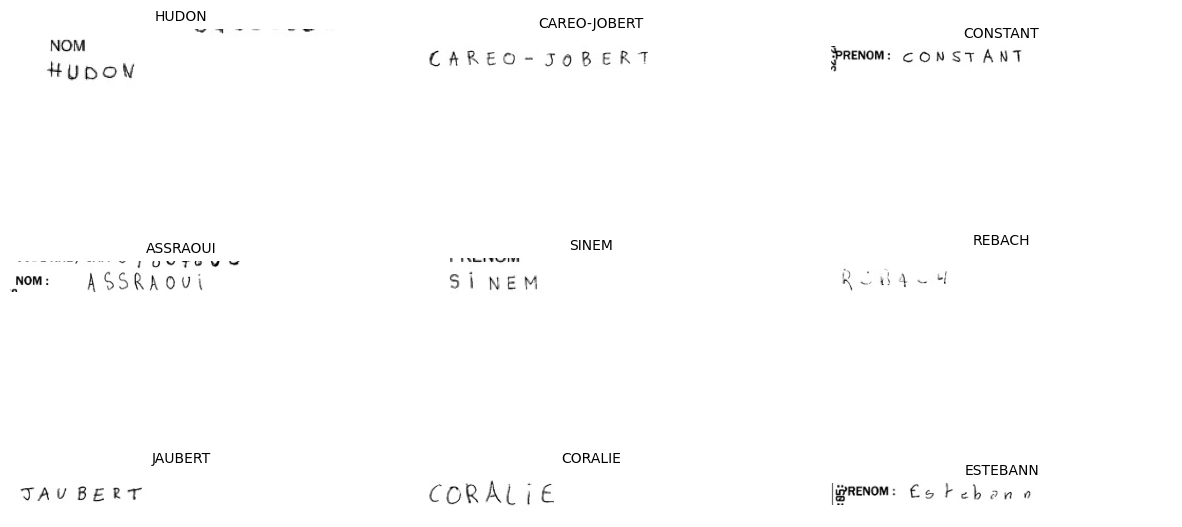

In [3]:
def visualization_data(data_csv, image_dir):
    # Set up the plot
    fig, axs = plt.subplots(3, 3, figsize=(15, 8))
    
    # Loop over the random images and plot the bounding boxes
    for i in range(9):
        row = i // 3
        col = i % 3
        
        idx = random.randint(0, 1000)
        # Load the image
        image_path = os.path.join(image_dir, data_csv.loc[idx, 'FILENAME'])
        image = cv2.imread(image_path, 0)
        axs[row, col].imshow(image, cmap = 'gray')
        axs[row, col].set_title(data_csv.loc[idx, 'IDENTITY'], fontsize=10)
        axs[row, col].axis('off')
    plt.show()
    
visualization_data(train_csv, train_img_dir)

In [4]:
train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']
val_csv = val_csv[val_csv['IDENTITY'] != 'UNREADABLE']
print(train_csv.shape[0], val_csv.shape[0])

330859 41358


In [5]:
alphabets = string.ascii_uppercase + "' -"
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64 # max length of predicted labels: 64
batch_size = 512

def encode_to_label(text):
    # Encoding each output word into digits
    dig_list = []
    for char in str(text):
        idx = alphabets.find(char)
        dig_list.append(idx if idx!=-1 else alphabets.find('-'))
    
    return pad_sequences([dig_list], maxlen=max_str_len, padding='post', value=-1)[0]

name = 'QUY DAU'
print(name, '\n', encode_to_label(name))

QUY DAU 
 [16 20 24 27  3  0 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [6]:
def decode_to_text(number_arr):
    text = ''
    for number in number_arr:
        if number == -1: # CTC blank
            break
        else:
            text += alphabets[number]

    return text

decode_to_text([16, 20, 24, 27, 3, 0, 20, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

'QUY DAU'

In [7]:
@tf.function
def preprocess_image(image_path, label, label_len):
    # Read image
    file = tf.io.read_file(image_path)
    # Decode and convert to grayscale
    image = tf.image.decode_png(file, channels=1)
    # Convert to float32 in [0, 1] range
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image
    image = tf.image.resize(image, [64, 256])
    # Compute the input_len
    input_len = [num_of_timestamps - 2]
    
    return image, label, input_len, label_len, [0]

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Function for Create list of image data
def create_data_list(data_csv, img_dir):
    data_x, data_y, label_len = [], [], []
    for idx, row in data_csv.iterrows():
        if isinstance(row['IDENTITY'], str):
            data_x.append(os.path.join(img_dir, row['FILENAME']))
            text = row['IDENTITY'].upper()
            data_y.append(encode_to_label(text))
            label_len.append(len(text))
        
    return data_x, data_y, label_len

# Function for Create tensorflow dataset
def create_tf_dataset(data_x, data_y, label_len):
    dataset = tf.data.Dataset.from_tensor_slices((data_x, data_y, label_len))
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(batch_size)
    dataset = dataset.map(lambda *x: (x[0:-1],x[-1])).prefetch(AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
    return dataset

In [9]:
# Create tensorflow Dataset for train data
train_x, train_y, train_label_len = create_data_list(train_csv, train_img_dir)
train_dataset = create_tf_dataset(train_x, train_y, train_label_len)

# Create tensorflow Dataset for val data
val_x, val_y, val_label_len = create_data_list(val_csv, val_img_dir)
val_dataset = create_tf_dataset(val_x, val_y, val_label_len)

print(len(train_y), len(val_y))

2024-05-15 13:07:07.660123: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 13:07:08.501645: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14540 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
330294 41280


In [10]:
# Defining the CTC loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [11]:
def conv_block(num_filters, use_max_pool=True, pool_size=(4, 2), stride=2):
    cnn = Sequential()
    cnn.add(Conv2D(num_filters, (3, 3), activation="relu", padding="same"))
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D(pool_size=pool_size, strides=stride))
    return cnn
    
# Define the CRNN Model
def CRNN():
    # Inputs
    inputs = Input(shape=(64, 256, 1), name='image')
    labels = Input(name="label", shape=(None,), dtype="float32")
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    
    # CNN
    conv1 = conv_block(32)(inputs)
    conv2 = conv_block(64)(conv1)
    conv3 = conv_block(128, pool_size=(4, 1), stride=1)(conv2)
    conv4 = conv_block(256, pool_size=(4, 1), stride=1)(conv3)
    conv5 = conv_block(128, pool_size=(5, 1), stride=1)(conv4)

    # CNN --> RNN
    reshape = Reshape((num_of_timestamps, 512))(conv5)
    dense = Dense(num_of_timestamps, activation='relu')(reshape)
    bn = BatchNormalization()(dense)
    dropout = Dropout(0.2)(bn)
    
    # RNN
    lstm1 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2))(dropout)
    lstm2 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2))(lstm1)
    
    # Outputs
    y_pred = Dense(num_of_characters, activation = 'softmax')(lstm2)
    ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    
    pred_model = Model(inputs=inputs, outputs=y_pred)
    train_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=ctc_loss)
    
    return pred_model, train_model

model, train_model = CRNN()
train_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 64, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 sequential (Sequential)        (None, 31, 128, 32)  448         ['image[0][0]']                  
                                                                                                  
 sequential_1 (Sequential)      (None, 14, 64, 64)   18752       ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 11, 64, 128)  74368       ['sequential_1[0][0]']     

In [13]:
# Compile the model
train_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred},
                    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0))

# filepath = "/kaggle/working/best_model.weights.h5"

# # function callback
# checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor= 'val_loss',
#                              verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

earlyStopping = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
callbacks_list = [earlyStopping]

# method 1
history = train_model.fit(train_dataset,
                          epochs=30,
                          validation_data=val_dataset,
                          verbose = 1,
                          shuffle=True, 
                          callbacks=callbacks_list)

# Save the model
# model.save('/kaggle/working/my_model.h5')

Epoch 1/30


2024-05-15 13:08:09.766241: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:433] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2024-05-15 13:08:09.766332: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Possibly insufficient driver version: 470.239.6
2024-05-15 13:08:09.766357: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops_fused_impl.h:621 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node 'model_1/sequential/conv2d/Relu' defined at (most recent call last):
    File "/anaconda/envs/py38_default/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/anaconda/envs/py38_default/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/anaconda/envs/py38_default/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/anaconda/envs/py38_default/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/anaconda/envs/py38_default/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_58385/109080807.py", line 16, in <module>
      history = train_model.fit(train_dataset,
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 314, in call
      return self.activation(outputs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/backend.py", line 5369, in relu
      x = tf.nn.relu(x)
Node: 'model_1/sequential/conv2d/Relu'
Detected at node 'model_1/sequential/conv2d/Relu' defined at (most recent call last):
    File "/anaconda/envs/py38_default/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/anaconda/envs/py38_default/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/anaconda/envs/py38_default/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/anaconda/envs/py38_default/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/anaconda/envs/py38_default/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_58385/109080807.py", line 16, in <module>
      history = train_model.fit(train_dataset,
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 314, in call
      return self.activation(outputs)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/backend.py", line 5369, in relu
      x = tf.nn.relu(x)
Node: 'model_1/sequential/conv2d/Relu'
2 root error(s) found.
  (0) UNIMPLEMENTED:  DNN library is not found.
	 [[{{node model_1/sequential/conv2d/Relu}}]]
	 [[model_1/ctc/ArithmeticOptimizer/ReorderCastLikeAndValuePreserving_int32_Squeeze_1/_88]]
  (1) UNIMPLEMENTED:  DNN library is not found.
	 [[{{node model_1/sequential/conv2d/Relu}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_30036]

In [ ]:
# Visualize the training process

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Load the best model
# model.load_weights('/kaggle/working/best_model.h5')


In [ ]:
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indices = np.argmax(predictions, axis=2)
    
    for i in range(pred_indices.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indices[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(alphabets):
                ans += alphabets[int(p)]
        
        text_list.append(ans)
        
    return text_list

In [ ]:
def get_predictions_and_labels(dataset, model):
    """
    Input: Tensorflow Dataset and the model to predict
    Output: Extract labels from dataset and get prediction from the model
    """
    predictions, labels = [], []
    for batch in dataset.as_numpy_iterator():
        images, num_labels = batch[0][0], batch[0][1]
        preds = model.predict(images)
        predictions.extend(ctc_decoder(preds))
        labels.extend([decode_to_text(num_labels[i]) for i in range(len(num_labels))])
    
    return predictions, labels

predictions, labels = get_predictions_and_labels(val_dataset, model)
print(len(predictions), len(labels))

In [ ]:
def get_accuracy_characters_and_words(predictions, labels):
    """
    Input: The predictions and labels text of validation data
    Output: The accuracy about words and characters
    """
    word_accuracy = np.mean([predictions[i] == labels[i] for i in range(len(predictions))])
    num_correct_char, len_char = 0, 0
    for i in range(len(predictions)):
        num_correct_char += np.sum([predictions[i][j] == labels[i][j] for j in range(min(len(predictions[i]), len(labels[i])))])
        len_char += len(labels[i])
    
    character_accuracy = num_correct_char/ float(len_char)
    return word_accuracy, character_accuracy

word_accuracy, character_accuracy = get_accuracy_characters_and_words(predictions, labels)
print('Character accuracy in the validation set: {} %'.format(round(character_accuracy * 100, 3)))
print('Word accuracy in the validation set: {} %'.format(round(word_accuracy * 100, 3)))


In [ ]:
# Declare image directory and label csv file for the test dataset
test_img_dir = '/kaggle/input/handwriting-recognition/test_v2/test'
test_csv = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

# Create test dataset with TensorFlow format
test_x, test_y, test_label_len = create_data_list(test_csv, test_img_dir)
test_dataset = create_tf_dataset(test_x, test_y, test_label_len)

In [ ]:
def test_images_data_with_model_prediction(model, dataset):
    # Create predictions for a batch in this dataset
    for batch in dataset.as_numpy_iterator():
        images = batch[0][0]
        predictions = ctc_decoder(model.predict(images))
        break
    
    # Set up the plot
    fig, axs = plt.subplots(3, 3, figsize=(15, 8))
    
    # Loop over the random images and plot the image with prediction model
    for i in range(9):
        row = i // 3
        col = i % 3
        
        idx = random.randint(0, batch_size)
        axs[row, col].imshow(images[idx], cmap = 'gray')
        axs[row, col].set_title('Prediction: {}'.format(predictions[idx]), fontsize=12)
        axs[row, col].axis('off')
    plt.show()

test_images_data_with_model_prediction(model, test_dataset)